Load necessary libraries

In [10]:
import numpy as np 
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.datasets import load_files
import torch.optim as optim
from torchvision.utils import make_grid
from torchvision import transforms
from torch.utils.data import Dataset
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from glob import glob
print(os.listdir("../input"))

['fruits-360']


Counting images in train and test

In [11]:
path='../input/fruits-360'
img_tr= glob(os.path.join(path,'Training', '*/*.jpg'))
num_images = len(img_tr)
print('Number of images in train:', num_images)
img_tst= glob(os.path.join(path,'Test', '*/*.jpg'))
num_images = len(img_tst)
print('Number of images in test:', num_images)

Number of images in train: 67692
Number of images in test: 22688


A bit of image statistics

In [12]:
min_images = 1000
im_cnt = [] #image count
class_names = [] #class list
for folder in os.listdir(os.path.join(path, 'Training')):
    folder_num = len(os.listdir(os.path.join(path,'Training',folder)))
    im_cnt.append(folder_num)
    class_names.append(folder)
    if (folder_num < min_images):
        min_images = folder_num
        folder_name = folder
        
num_classes = len(class_names)
print("Min images in class", min_images)    
print('Avg images in class: {:.0f}'.format(np.array(im_cnt).mean()))
print('Class count: {}'.format(num_classes))

Min images in class 297
Avg images in class: 517
Class count: 131


Find the mean and std of each channel

In [13]:
tensor_transform = transforms.Compose([
    transforms.ToTensor()
])
#loading data
all_data = ImageFolder(os.path.join(path, 'Training'), tensor_transform)
data_loader = torch.utils.data.DataLoader(all_data, batch_size=512, shuffle=True)
pop_mean = []
pop_std = []
#cycle for mean and std of channels in batches in datatloader
for i, data in enumerate(data_loader, 0):
    numpy_image = data[0].numpy()
    
    batch_mean = np.mean(numpy_image, axis=(0,2,3))
    batch_std = np.std(numpy_image, axis=(0,2,3))
    
    pop_mean.append(batch_mean)
    pop_std.append(batch_std)

pop_mean = np.array(pop_mean).mean(axis=0)
pop_std = np.array(pop_std).mean(axis=0)
print(pop_mean)
print(pop_std)

[0.684063  0.5786381 0.5036611]
[0.3033455  0.359862   0.39138278]


Setting shuffle seed and getting train_validation split

In [14]:
#setting random seed for image shuffling, getting validation and training split lengths
np.random.seed(123)
shuffle = np.random.permutation(num_images)
split_val = int(num_images * 0.2)
print('Total images', num_images)
print('Validation count',len(shuffle[:split_val]))
print('Train count',len(shuffle[split_val:]))

Total images 22688
Validation count 4537
Train count 18151


Class for dataset

In [15]:
#classes for datasets
#found on internet, just too beautiful not to use
class FruitTrainDataset(Dataset):
    #init
    def __init__(self, files, shuffle, split_val, class_names, transform=transforms.ToTensor()):
        self.shuffle = shuffle
        self.class_names = class_names
        self.split_val = split_val
        self.data = np.array([files[i] for i in shuffle[split_val:]])
        self.transform=transform
    #len 
    def __len__(self):
        return len(self.data)
    #getting item
    def __getitem__(self, idx):
        img = Image.open(self.data[idx])
        name = self.data[idx].split('/')[-2]
        y = self.class_names.index(name)
        img = self.transform(img)
        return img, y

class FruitValidDataset(Dataset):
    def __init__(self, files, shuffle, split_val, class_names, transform=transforms.ToTensor()):
        self.shuffle = shuffle
        self.class_names = class_names
        self.split_val = split_val
        self.data = np.array([files[i] for i in shuffle[:split_val]])
        self.transform=transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img = Image.open(self.data[idx])
        name = self.data[idx].split('/')[-2]
        y = self.class_names.index(name)
        img = self.transform(img)  
        return img, y
    
class FruitTestDataset(Dataset):
    def __init__(self, path, class_names, transform=transforms.ToTensor()):
        self.class_names = class_names
        self.data = np.array(glob(os.path.join(path, '*/*.jpg')))
        self.transform=transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img = Image.open(self.data[idx])
        name = self.data[idx].split('/')[-2]
        y = self.class_names.index(name)
        img = self.transform(img)
        return img, y
    

Setting trasformations of images (random flips for training, normalization for everything) and creating datasets

In [28]:
#transforms, don't forget normalization
tr_tmfs = transforms.Compose([
        transforms.RandomHorizontalFlip(0.3),
        transforms.RandomVerticalFlip(0.3),
        transforms.ToTensor(),
        transforms.Normalize(pop_mean, pop_std)])
tst_tmfs = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(pop_mean, pop_std)
    ])
val_tmfs = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(pop_mean, pop_std)
    ])
train_dataset = FruitTrainDataset(img_tr, shuffle, split_val, class_names, tr_tmfs)
valid_dataset = FruitValidDataset(img_tr, shuffle, split_val, class_names, val_tmfs)
test_dataset = FruitTestDataset('../input/fruits-360/Test', class_names, tst_tmfs)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=True)

Dicts for usability

In [29]:
dataloaders = {'train': train_loader,
              'valid': valid_loader,
              'Test': test_loader}
dataset_sizes = {
    'train': len(train_dataset),
    'valid': len(valid_dataset),
    'Test': len(test_dataset)
}

Draw image to represent images in dataset

In [42]:
#found on internet
def imshow(img, title=None):
    img = img.numpy().transpose((1, 2, 0))
    inp = pop_std * img + pop_mean
    img = np.clip(inp, 0, 1)
    plt.imshow(img, aspect='auto')

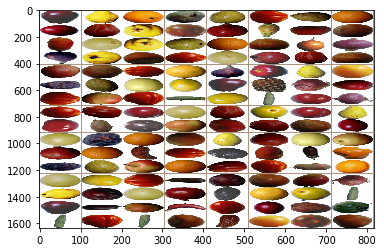

In [43]:
inputs, classes = next(iter(train_loader))
out = make_grid(inputs)  
imshow(out)

Dict for classes to represent them with numbers

In [20]:
d = {}
for i in range(len(class_names)):
    d[i] = class_names[i]

Network class

In [36]:
"""
3 nets to try out with different architectures
"""
class Net(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5)
        self.conv1_bn = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 64, kernel_size=3)
        self.conv2_bn = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 256, kernel_size=3)
        self.conv3_bn = nn.BatchNorm2d(256)
        self.l1 = nn.Linear(256 * 10 * 10, 128)
        self.l2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1_bn(self.conv1(x))))
        x = self.pool(F.relu(self.conv2_bn(self.conv2(x))))
        x = self.pool(F.relu(self.conv3_bn(self.conv3(x))))
        x = x.view(-1, 256 * 10 * 10)
        x = F.dropout(F.relu(self.l1(x)), p=0.2)
        x = self.l2(x)
        return F.log_softmax(x, dim=1) 

class Net1(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5)
        self.conv1_bn = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        self.conv2_bn = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv3_bn = nn.BatchNorm2d(64)
        self.l1 = nn.Linear(64 * 10 * 10, 128)
        self.l2 = nn.Linear(128, 256)
        self.l3 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1_bn(self.conv1(x))))
        x = self.pool(F.relu(self.conv2_bn(self.conv2(x))))
        x = self.pool(F.relu(self.conv3_bn(self.conv3(x))))
        x = x.view(-1, 64 * 10 * 10)
        x = F.dropout(F.relu(self.l1(x)), p=0.1)
        x = F.dropout(F.relu(self.l2(x)), p=0.4)
        x = self.l3(x)
        return F.log_softmax(x, dim=1) 
    

class Net2(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5)
        self.conv1_bn = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        self.conv2_bn = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 128, kernel_size=3)
        self.conv3_bn = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3)
        self.conv3_bn = nn.BatchNorm2d(256)
        self.l1 = nn.Linear(256 * 10 * 10, 256)
        self.l2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1_bn(self.conv1(x))))
        x = self.pool(F.relu(self.conv2_bn(self.conv2(x))))
        x = self.pool(F.relu(self.conv3_bn(self.conv3(x))))
        x = x.view(-1, 64 * 10 * 10)
        x = F.dropout(F.relu(self.l1(x)), p=0.1)
        x = self.l2(x)
        return F.log_softmax(x, dim=1) 

Check for GPU

In [37]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Using somewhat classical criterion, optimizer for the task. In earlier stages other options were tried out, did not work so well

In [39]:
model = Net(num_classes)
model.to(device)
model1 = Net1(num_classes)
model1.to(device)
model2 = Net2(num_classes)
model2.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.005)
criterion = nn.CrossEntropyLoss()
exp_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Fitting the network

In [40]:
def fit(model, criterion, optimizer, scheduler, num_epochs=30):
    acc = []
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        for phase in ['train', 'valid']:
            #pick out phase and model operatio type
            if phase == 'train':
                scheduler.step()
                model.train()
            else:
                model.eval()
            _loss = 0.0
            _corrects = 0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device) 
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()    
                _loss += loss.item() * inputs.size(0)
                _corrects += torch.sum(preds == labels.data)
            # count loss and accuracy
            epoch_loss = _loss / dataset_sizes[phase]
            epoch_acc = _corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            acc.append(epoch_acc)     
        print()
    return model, acc

In [44]:
model, acc = fit(model, criterion, optimizer, exp_scheduler, num_epochs=15)
model1, acc1 = fit(model, criterion, optimizer, exp_scheduler, num_epochs=15)
model2, acc2 = fit(model, criterion, optimizer, exp_scheduler, num_epochs=15)

Epoch 0/14
train Loss: 0.3142 Acc: 0.9325
valid Loss: 0.1846 Acc: 0.9716

Epoch 1/14
train Loss: 0.2499 Acc: 0.9489
valid Loss: 0.1600 Acc: 0.9729

Epoch 2/14
train Loss: 0.2131 Acc: 0.9587
valid Loss: 0.1383 Acc: 0.9797

Epoch 3/14
train Loss: 0.2088 Acc: 0.9607
valid Loss: 0.1332 Acc: 0.9821

Epoch 4/14
train Loss: 0.2004 Acc: 0.9625
valid Loss: 0.1333 Acc: 0.9802

Epoch 5/14
train Loss: 0.1966 Acc: 0.9651
valid Loss: 0.1284 Acc: 0.9828

Epoch 6/14
train Loss: 0.1925 Acc: 0.9644
valid Loss: 0.1277 Acc: 0.9826

Epoch 7/14
train Loss: 0.1925 Acc: 0.9643
valid Loss: 0.1245 Acc: 0.9857

Epoch 8/14
train Loss: 0.1874 Acc: 0.9666
valid Loss: 0.1192 Acc: 0.9855

Epoch 9/14
train Loss: 0.1859 Acc: 0.9662
valid Loss: 0.1219 Acc: 0.9837

Epoch 10/14
train Loss: 0.1873 Acc: 0.9661
valid Loss: 0.1205 Acc: 0.9835

Epoch 11/14
train Loss: 0.1863 Acc: 0.9639
valid Loss: 0.1185 Acc: 0.9848

Epoch 12/14
train Loss: 0.1842 Acc: 0.9680
valid Loss: 0.1182 Acc: 0.9837

Epoch 13/14
train Loss: 0.1842 Acc:

Drawing accuracy on train and validation

In [45]:
acc_val = acc[1::2]
acc_tr = acc[::2]
acc1_val = acc1[1::2]
acc1_tr = acc1[::2]
acc2_val = acc2[1::2]
acc2_tr = acc2[::2]

Text(0,0.5,'accuracy')

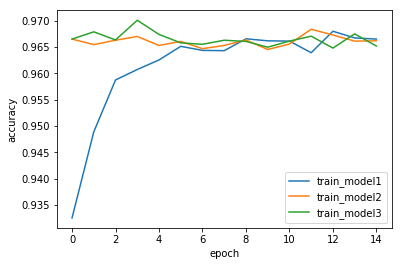

In [46]:
plt.plot(acc_tr)
plt.plot(acc1_tr)
plt.plot(acc2_tr)
plt.legend(['train_model1', 'train_model2', 'train_model3'])
plt.xlabel('epoch')
plt.ylabel('accuracy')

Text(0,0.5,'accuracy')

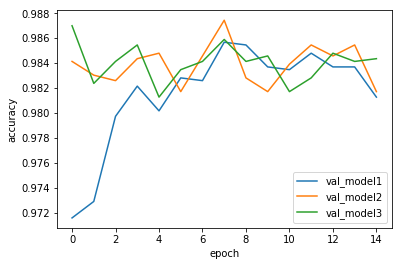

In [47]:
plt.plot(acc_val)
plt.plot(acc1_val)
plt.plot(acc2_val)
plt.legend(['val_model1', 'val_model2', 'val_model3'])
plt.xlabel('epoch')
plt.ylabel('accuracy')

Looks like the first one is the easiest to learn, also graphs for it are more or less better

In [48]:
for m in [model, model1, model2]:
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloaders['Test']:
            images = images.to(device)
            labels = labels.to(device)
            outputs = m(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('Accuracy on test images: {:.3f}%'.format(dataset_sizes['Test'], 
                                                                          100 * correct / dataset_sizes['Test']))

Accuracy on test images: 22688.000%
Accuracy on test images: 22688.000%
Accuracy on test images: 22688.000%


Choosing the first model, looks the most accurate. Saving it's state

In [49]:
torch.save(model.state_dict(), "../working/model.pickle")